In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble as ske
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV , train_test_split
from stroopwafel import constants , utils
from sklearn import metrics , tree
import seaborn as sns
from numpy import array as A
from sklearn.utils import shuffle
import cython
from cython.parallel import prange , parallel
from cython import nogil
import random
from sklearn.preprocessing import OneHotEncoder
import pickle
from mpl_toolkits import mplot3d

# Function definition



In [7]:
%%cython

# cython: auto_pickle=False
# distutils: extra_compile_args = /openmp
# distutils: extra_link_args = /openmp
# cython: boundscheck = False

import cython
import numpy as np
cimport numpy as np
cimport openmp
from cython.parallel import prange, parallel, threadid
from libc.stdlib cimport malloc, realloc, free, abort
from libc.math cimport cos , sin , sqrt , tan

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)

cdef Hot_Encode(int L , int n_class , int n_var , double [:,:] dataset , int [:,:] labels , int num_t):
    
    cdef double [:,:] DATASET = dataset[0:L,:]  
    cdef int [:,:] LABELS = labels[0:L,:]
    cdef int i , j
    cdef int [:] merge = labels[:,0]
    cdef int [:] bbh = labels[:,1]
    cdef double [:,:,:] ds
    
    if n_class >= n_var:
        ds = np.zeros( (2 , L , n_class) )
    else:
        ds = np.zeros( (2 , L , n_var) )

    for i in prange(L , nogil = True , schedule = 'static' , num_threads = num_t):
        
        for j in range(n_var):
            ds[0,i,j] = DATASET[i,j]
        
        if merge[i] == 1: # BBH MERGER

            ds[1,i,0] = 1
                
        else: # BBH NO MERGER:
            
            ds[1,i,1] = 1
        
    return ds

def hotencode(int L , int n_class , int n_var , double [:,:] dataset , int [:,:] labels , int num_t):
    return Hot_Encode(L , n_class , n_var , dataset , labels , num_t)

print('Hotencoding ok!')

def Equalize(variable , label , minimum , n , L , least):
    
    lab = []
    var = []
    
    for i in range(L):
        if label.iloc[i,least] == 1:
            lab.append(label.iloc[i].values)
            var.append(variable.iloc[i].values)

    for N in range(n):
        k = 0
        for j in range(L):
            if label.iloc[j,N] == 1 and k <= minimum-1 and N != least:
                lab.append(label.iloc[j].values)
                var.append(variable.iloc[j].values)
                k += 1
                
    return np.array(lab) , np.array(var)

print('Equalize ok!')

# Dataset Creation for hyperparameters optimization

In [8]:
dataset1 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_1.csv')
dataset2 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_2.csv')
dataset3 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_3.csv')

frames = [dataset1 , dataset2 , dataset3] # merge the dataset

dataset = pd.concat(frames)
print(len(dataset))

dataset = dataset[ dataset.bbh == 1. ] # taaking only a part of the dataset
dataset = shuffle(dataset)

VAR = dataset[['--initial-mass-1' , 'q' , '--metallicity' , '--semi-major-axis' , '--eccentricity']].astype(float)
LAB = dataset[['is_hit']].astype(int)

n = 2 # number of classes
m = 5 # number of variables
threads = 8 # number of threads
L = 10000 # portion of the dataset to take

ds = hotencode(L , n , m , VAR.values , LAB.values , threads) # one hot encoding

variables = np.array(ds[0,:,0:m])
labels = np.array(ds[1,:,0:n]).astype(int)

names = ['BBH_MERGE' , 'BBH_NO_MERGE']

### Check if all the dataset is represented

LEAST = []
c = 0
for i in range(n):
    c += 100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))) , '% ---->' , np.count_nonzero(labels[:,i] == 1))
    LEAST.append(np.count_nonzero(labels[:,i] == 1))
    
least_repr = np.argmin(LEAST)
    
if c >= 99.9:
    print('')
    print('OK! All dataset is represented!')

### Computation of the value of how much elements are in the less represented class 
    
counts = np.zeros(n)
for i in range(n):
    counts[i] = np.count_nonzero(labels[:,i] == 1)
minimum = int(np.min(counts))

print('')
print('Minimum = ' , minimum)
print('')

LABELS = pd.DataFrame(labels , columns = names , dtype = int)
VARIABLES = pd.DataFrame(variables , columns = ['M1' , 'q' , 'Z' , 'a' , 'e'])

lab , var = Equalize(VARIABLES , LABELS , minimum , n , L , least_repr) # Equalization

### Check if the dataset is equalized

for i in range(n):
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(lab[:,i] == 1)/len(lab[:,i]))) , '% ---->' , np.count_nonzero(lab[:,i] == 1))

2028000
BBH_MERGE 32.60.. % ----> 3260
BBH_NO_MERGE 67.40.. % ----> 6740

OK! All dataset is represented!

Minimum =  3260

BBH_MERGE 50.00.. % ----> 3260
BBH_NO_MERGE 50.00.. % ----> 3260


In [9]:
# train test split to give the data to sklearn

datasetX = var

datasetY = lab

Xtrain, Xtest, ytrain, ytest = train_test_split( datasetX , datasetY , test_size = 0.000001 , random_state = 311996 )

print(len(Xtrain) , len(ytrain) , len(Xtest) , len(ytest))

6519 6519 1 1


# Random Search

In [10]:
# Number of trees in random forest
n_estimators = np.arange(100 , 1100 , 100).tolist()

# Number of features to consider at every split
max_features = ['sqrt' , 'log2' , 'auto']

# Maximum number of levels in tree
max_depth = np.arange(0,110,10 , dtype = int).tolist()
max_depth.append(None)
max_depth.append(np.arange(1,10).tolist())

# Minimum number of samples required to split a node
min_samples_split = np.arange(2,11,1).tolist()

# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(2,11,1).tolist()

# Method of selecting samples for training each tree
bootstrap = [True , False]

criterion = ["gini" , "entropy"]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
print(random_grid)

# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 60 different combinations, and use all available cores

rf_random = RandomizedSearchCV( estimator = ske.RandomForestClassifier(n_jobs = -1) , 
                                param_distributions = random_grid , n_iter = 500 ,
                                cv = 5, verbose = 2 , random_state = 3117102616 , n_jobs = -1 , pre_dispatch = '2*n_jobs' ) 

# Fit the random search model
rf_random.fit(var , lab)

print(rf_random.best_params_)

print('Best accuracy score: %.4f' , rf_random.best_score_)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['sqrt', 'log2', 'auto'], 'max_depth': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None, [1, 2, 3, 4, 5, 6, 7, 8, 9]], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']}
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 61.3min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 78.9min finished


{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'gini', 'bootstrap': False}
Best accuracy score: %.4f 0.7532208588957054


# Grid Search

In [11]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80 , 90 , 100 , 110 , 120],
    'n_estimators': [225 ,250 , 275 , 300 , 225 , 250 , 275],
    'min_samples_leaf': [2,3],
    'min_samples_split': [4,5,6],
    'max_features': ['log2'],
    'bootstrap': [False],
    'criterion': ['gini']
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ske.RandomForestClassifier(n_jobs = -1),
                           param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2 , pre_dispatch = '2*n_jobs')

grid_search.fit(Xtrain , ytrain)

print(grid_search.best_params_)
print('Best accuracy score: %.4f' , grid_search.best_score_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 16.7min finished


{'bootstrap': False, 'criterion': 'gini', 'max_depth': 90, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 275}
Best accuracy score: %.4f 0.8370892560349171


# Dataset creation for training and testing

In [12]:
dataset1 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_1.csv')
dataset2 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_2.csv')
dataset3 = pd.read_csv('C:/Users/mbaro/OneDrive/Desktop/dataset_ML/samples_3.csv')

frames = [dataset1 , dataset2 , dataset3]

dataset = pd.concat(frames) # merge of the datasets
print(len(dataset))

dataset = dataset[ dataset.bbh == 1. ] # taking only a portion of the dataset
dataset = shuffle(dataset)

VAR = dataset[['--initial-mass-1' , 'q' , '--metallicity' , '--semi-major-axis' , '--eccentricity']].astype(float)
LAB = dataset[['is_hit']].astype(int)# , 'bbh' ,]].astype(int)

n = 2 # number of classes
m = 5 # number of variables
threads = 8 # number of threads
L = len(dataset) # portion of the dataset to take

ds = hotencode(L , n , m , VAR.values , LAB.values , threads) # one hot encoding

variables = np.array(ds[0,:,0:m])
labels = np.array(ds[1,:,0:n]).astype(int)

names = ['BBH_MERGE' , 'BBH_NON_MERGE']

### Check if all the dataset is represented

LEAST = []
c = 0
for i in range(n):
    c += 100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(labels[:,i] == 1)/len(labels[:,i]))) , '% ---->' , np.count_nonzero(labels[:,i] == 1))
    LEAST.append(np.count_nonzero(labels[:,i] == 1))
    
least_repr = np.argmin(LEAST)
    
if c >= 99.9:
    print('')
    print('OK! All dataset is represented!')

### Computation of the value of how much elements are in the less represented class
    
counts = np.zeros(n)
for i in range(n):
    counts[i] = np.count_nonzero(labels[:,i] == 1)
minimum = int(np.min(counts))

print('')
print('Minimum = ' , minimum)
print('')

LABELS = pd.DataFrame(labels , columns = names , dtype = int)
VARIABLES = pd.DataFrame(variables , columns = ['M1' , 'q' , 'Z' , 'a' , 'e'])

lab , var = Equalize(VARIABLES , LABELS , minimum , n , L , least_repr) # Equalization

### Check if all the dataset is equally represented

for i in range(n):
    print(names[i] ,  '{:.2f}..'.format(100*(np.count_nonzero(lab[:,i] == 1)/len(lab[:,i]))) , '% ---->' , np.count_nonzero(lab[:,i] == 1))
    
# definition of the train and test dataset
    
datasetX = var

datasetY = lab

Xtrain, Xtest, ytrain, ytest = train_test_split( datasetX , datasetY ,
                                                 test_size = 0.2 , random_state = 754863321 )

print(len(Xtrain) , len(ytrain) , len(Xtest) , len(ytest))

2028000
BBH_MERGE 33.58.. % ----> 142686
BBH_NON_MERGE 66.42.. % ----> 282286

OK! All dataset is represented!

Minimum =  142686

BBH_MERGE 50.00.. % ----> 142686
BBH_NON_MERGE 50.00.. % ----> 142686
228297 228297 57075 57075


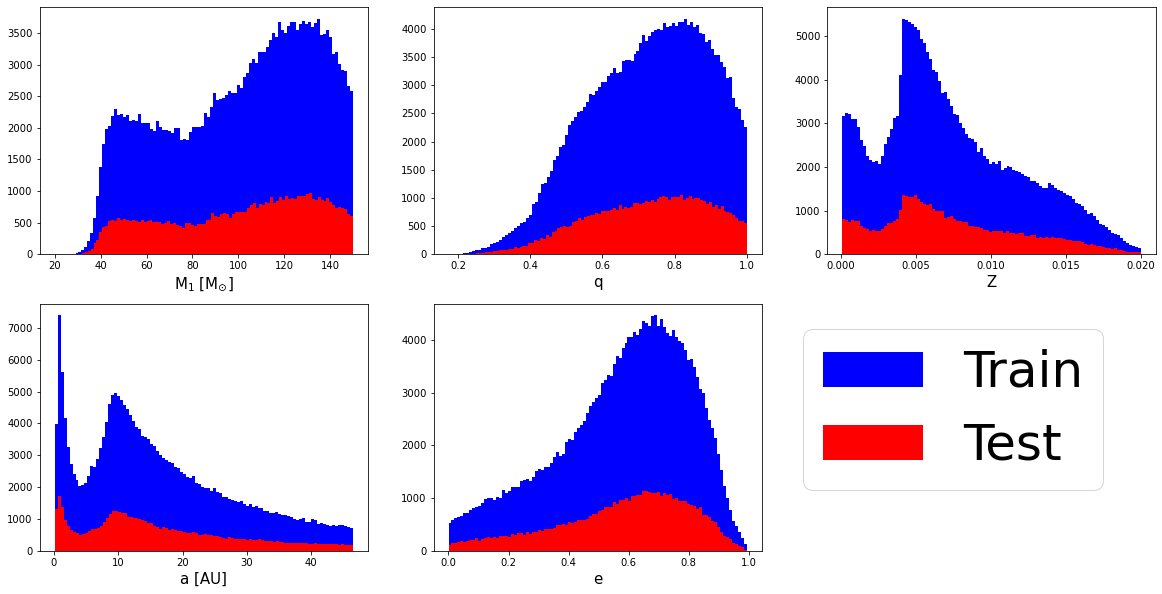

In [74]:
# dataset presentation

sns.reset_orig()
B = 100
fs = 15
fig, ax = plt.subplots(2 , 3 , figsize = [20,10])

ax[0][0].hist(Xtrain[:,0] , bins = B , color = 'blue' , label='Train')
ax[0][0].hist(Xtest[:,0] , bins = B , color = 'red' , label = 'Test')
ax[0][0].set_xlabel('M$_{1}$ [M$_{\odot}$]' , fontsize = fs)

ax[0][1].hist(Xtrain[:,1] , bins = B , color = 'blue' , label='Train')
ax[0][1].hist(Xtest[:,1] , bins = B , color = 'red' , label = 'Test')
ax[0][1].set_xlabel('q' , fontsize = fs)

ax[0][2].hist(Xtrain[:,2] , bins = B , color = 'blue' , label='Train')
ax[0][2].hist(Xtest[:,2] , bins = B , color = 'red' , label = 'Test')
ax[0][2].set_xlabel('Z' , fontsize = fs)
ax[0][2].set_xticks([0 , 0.005 , 0.01 , 0.015 , 0.02])

ax[1][0].hist(Xtrain[:,3] , bins = B , color = 'blue' , label='Train')
ax[1][0].hist(Xtest[:,3] , bins = B , color = 'red' , label = 'Test')
ax[1][0].set_xlabel('a [AU]' , fontsize = fs)

ax[1][1].hist(Xtrain[:,4] , bins = B , color = 'blue' , label='Train')
ax[1][1].hist(Xtest[:,4] , bins = B , color = 'red' , label = 'Test')
ax[1][1].set_xlabel('e' , fontsize = fs)
ax[1][1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' , prop={'size': 50})

fig.delaxes(ax[1][2])
plt.show()

# Training

In [15]:
final_model = ske.RandomForestClassifier(n_estimators = 275 , min_samples_split =4 ,
                                         min_samples_leaf = 2 ,
                                         max_features = 'log2' , max_depth = 90 ,
                                         bootstrap = False , criterion = "gini" , n_jobs = -1)
final_model.fit(Xtrain , ytrain)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='log2',
                       min_samples_leaf=2, min_samples_split=4,
                       n_estimators=275, n_jobs=-1)

# Testing

In [18]:
y_pred = final_model.predict(Xtest)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Mean Absolute Error: 0.08077091546211125
Mean Squared Error: 0.08077091546211125
Root Mean Squared Error: 0.2842022439427797
Accuracy: 0.9192115637319317
Score:  0.9192115637319317


# Option to use a saved model

In [26]:
filename = 'RandomForestBBH_BINARY_2million.sav'
loaded_model = pickle.load(open(filename, 'rb')) # using pickle to open a saved model
result = loaded_model.score(Xtest, ytest) # the score is the same as the accuracy 
y_pred = loaded_model.predict(Xtest)
print(result)

print('Mean Absolute Error:', metrics.mean_absolute_error(ytest, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ytest, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, y_pred)))
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

0.9192115637319317
Mean Absolute Error: 0.08077091546211125
Mean Squared Error: 0.08077091546211125
Root Mean Squared Error: 0.2842022439427797
Accuracy: 0.9192115637319317


# Feature Importance Histogram

a          0.254002
e          0.207685
Z          0.190573
M$_{1}$    0.183524
q          0.164216
dtype: float64


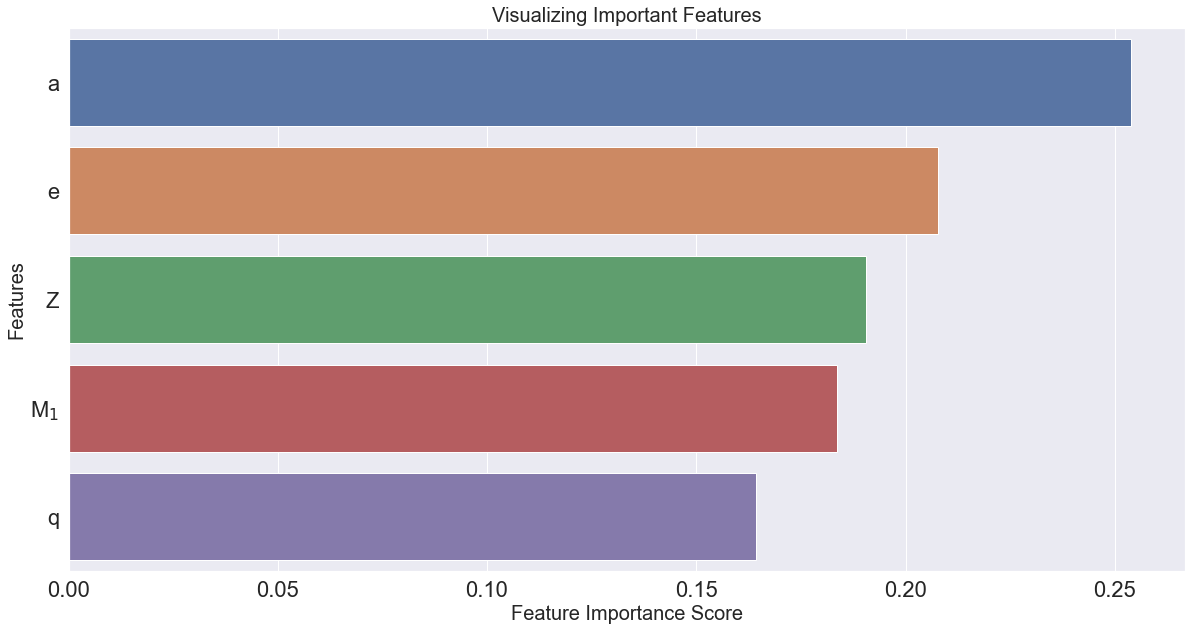

In [19]:
fig = plt.figure(figsize = [20,10])
feature_imp = pd.Series(final_model.feature_importances_ , index=['M$_{1}$' , 'q' , 'Z' , 'a' , 'e']).sort_values(ascending=False)
print(feature_imp)

sns.set(font_scale=2)

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score' , fontsize = 20)
plt.ylabel('Features' , fontsize = 20)
plt.title("Visualizing Important Features" , fontsize = 20)
plt.show()

fig.savefig('importance.png')

# Confusion Matrix

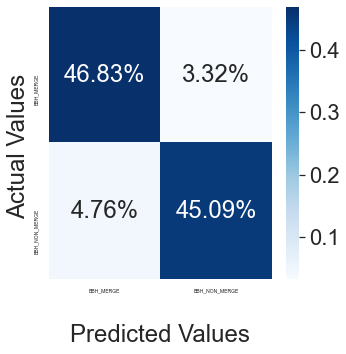

In [20]:
# Confusion matrix
# Evaluate confusion matrix

cm = metrics.confusion_matrix(ytest.argmax(axis=1), y_pred.argmax(axis=1))

##############################################################################

fig = plt.figure(figsize = [5,5])

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

ax.set_xticklabels(names , fontsize = 5)
ax.set_yticklabels(names , fontsize = 5)

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()
fig.savefig('conf_matrix_perc.png')

# Saving

In [21]:
filename = 'RandomForestBBH_BINARY_2million.sav'
pickle.dump(final_model, open(filename, 'wb'))

# Appendix - More Plots

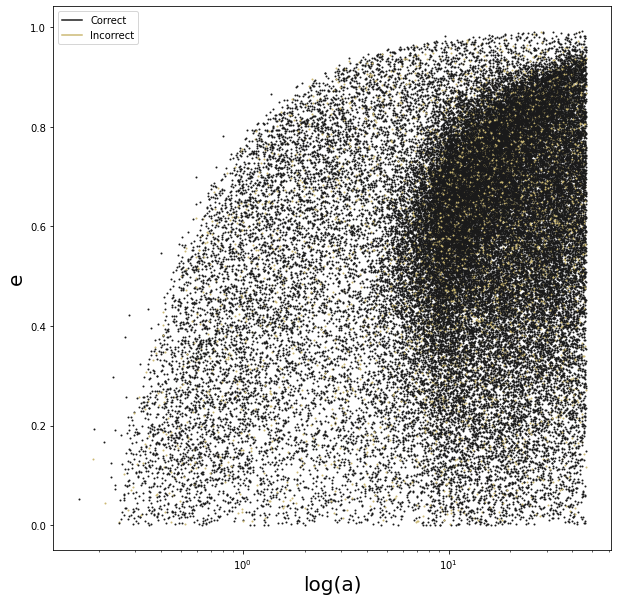

TypeError: scatter_3d() got an unexpected keyword argument 'c'

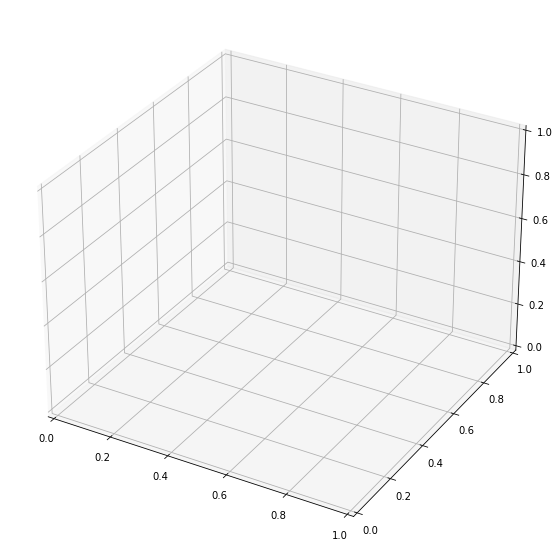

In [80]:
sns.reset_orig()
plt.figure(figsize = [10,10])
for i in range(len(ytest)):
    if ytest[i].tolist() == y_pred[i].tolist():
        plt.plot(Xtrain[i,3] , Xtrain[i,4] , 'k.' , markersize = 2)
    else:
        plt.plot(Xtrain[i,3] , Xtrain[i,4] , 'y.' , markersize = 2)
plt.xlabel('log(a)' , fontsize = 20)
plt.ylabel('e' , fontsize = 20)
plt.plot(0,0,'k-' , label = 'Correct')
plt.plot(0,0,'y-', label = 'Incorrect')
plt.xscale('log')
plt.legend()
plt.show()

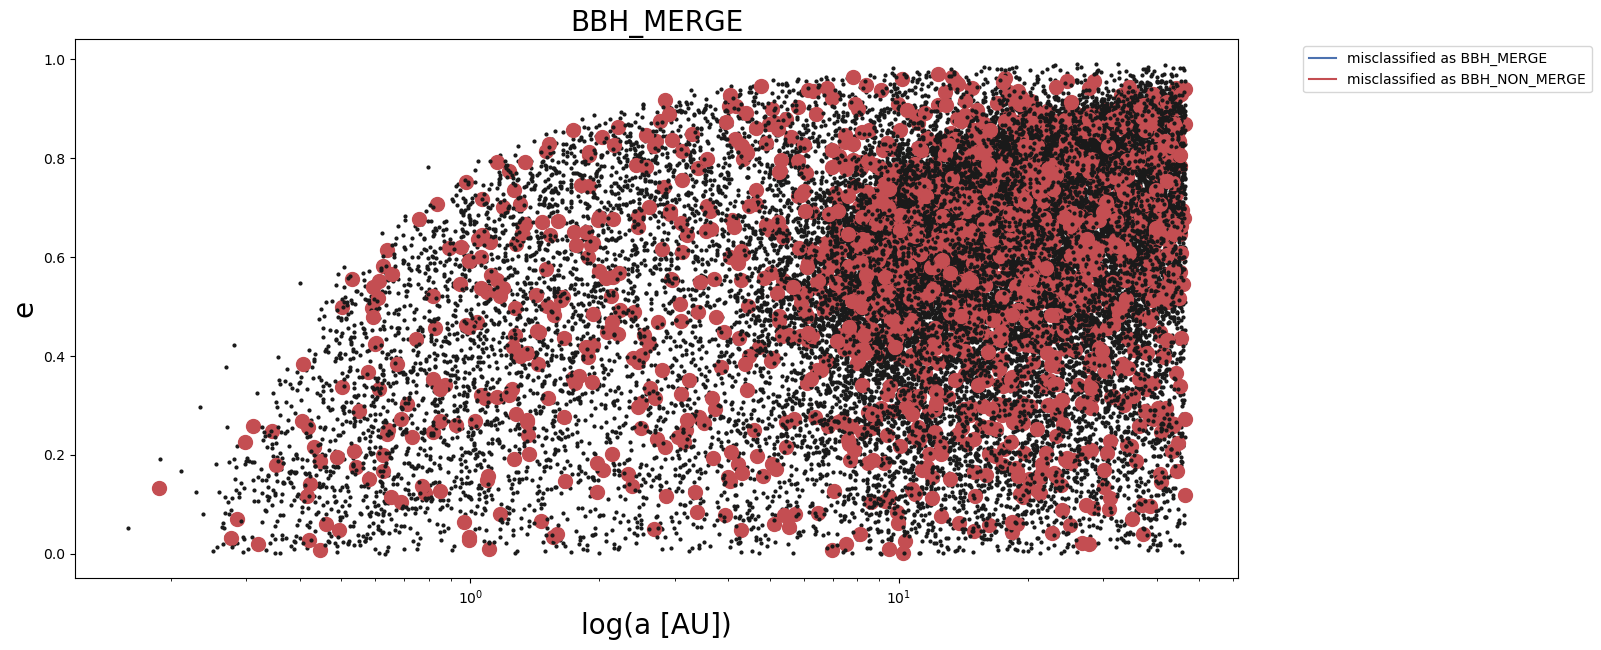

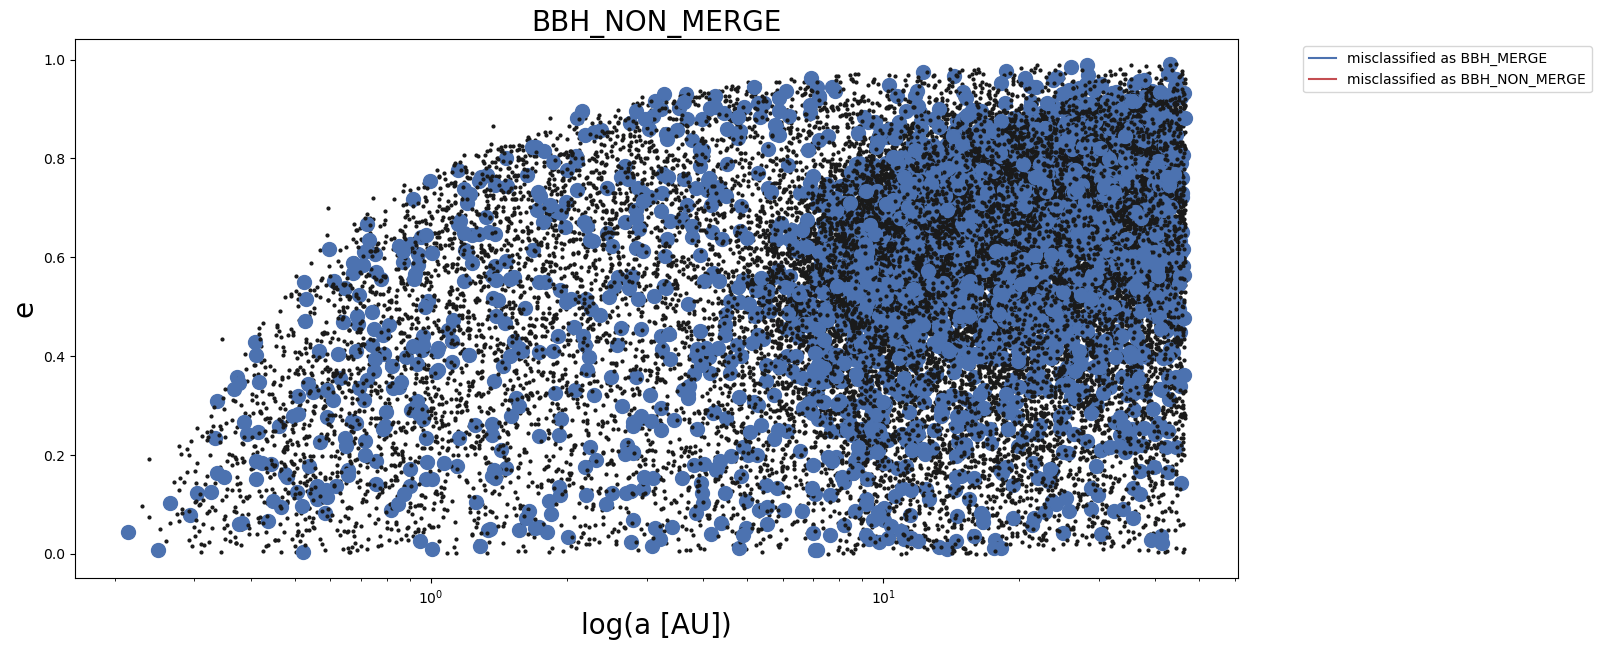

In [24]:
# FAI LA PCA E PLOTTA TUTTO IN 2 D e 3 D, POI FAI IL CLUSTERING
sns.reset_defaults()
colors = [str('b') , str('r')]

Y = np.eye(2)

for k in range(len(Y[0])):
    fig = plt.figure(figsize = [15,7])
    for i in range(len(ytest)):
        a = ytest[i].tolist()
        b = Y[k].tolist()
        c = y_pred[i].tolist()
        if a == b:
            if ytest[i].tolist() == y_pred[i].tolist():
                plt.plot(Xtrain[i,3] , Xtrain[i,4], 'ko' , markersize = 2)
            else:
                for j in range(len(Y[:,0])):
                    if c == Y[j].tolist() and c != Y[k].tolist():
                        plt.plot(Xtrain[i,3] , Xtrain[i,4], colors[j] + 'o' , markersize = 10)
                        
    for f in range(len(colors)):
        plt.plot(0,0,colors[f]+'-',markersize = 0 , label = 'misclassified as ' + names[k])
        plt.legend(loc='upper left')
    
    plt.title(names[k] , fontsize = 20)
    plt.ylabel('e' , fontsize  = 20)
    plt.xlabel('log(a [AU])' , fontsize  = 20)
    plt.xscale('log')
    plt.show()
    fig.savefig('PCA_2dim_binary_' + str(k) + '.png')